In [3]:
import os
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

root = '/kaggle/input/hierogliphs'
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = './gt.txt'

In [31]:
!pip install lmdb

# 

In [5]:
import cv2
import numpy as np

### Data tools

In [7]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [8]:
train_helper, val_helper = train_helper.train_val_split()

In [9]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [10]:
img, label = train_helper.get_item(42)

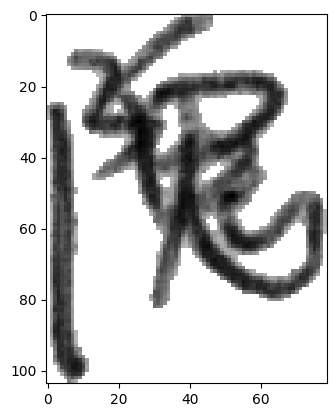

In [11]:
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')

In [12]:
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn

class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        return (cv2.resize(img, (256, 256)) - 127.5) / 255., label

In [15]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

### Model & training

In [17]:
from torchvision.models import ResNet50_Weights, resnet50
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, embedding_size=512):
        super().__init__()
        self.resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, embedding_size)
        
    def forward(self, x):
        x = self.resnet50(x.expand(-1, 3, -1, -1))
        return x

In [18]:
model = ResNet(train_helper.vocabulary.num_classes())
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s] 


ResNet(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [20]:
model(torch.tensor(train_dataset[0][0], dtype=torch.float32).view(1, 1, 256, 256))

tensor([[ 0.1441, -0.2023,  0.1813,  ..., -0.3169,  0.0287, -0.2269]],
       grad_fn=<AddmmBackward0>)

In [36]:
model = model.cuda()

In [22]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [33]:
from pytorch_metric_learning import losses

n_classes = train_helper.vocabulary.num_classes()

model = ResNet(512)
loss_fn = losses.ArcFaceLoss(num_classes=n_classes, embedding_size=512)
optim = torch.optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm


def run_validation(val_loader: DataLoader, model: nn.Module, n_steps=None):
    model.eval()
    n_good = 0
    n_all = 0
    wrapper = lambda x: x
    if n_steps is None:
        n_steps = len(val_loader)
        wrapper = tqdm
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(wrapper(val_loader)):
            if batch == n_steps:
                break
            logits = model(X.unsqueeze(1).to(torch.float32).cuda())
            classes = torch.argmax(logits, dim=1).cpu().numpy()
            n_good += sum(classes == y.cpu().numpy())
            n_all += len(classes)
    
    return n_good / n_all


def train_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn):
    for batch, (X, y) in enumerate(tqdm(train_loader)):
        model.train()
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        loss = loss_fn(logits, y.to(torch.long).cuda())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

In [68]:
torch.save(model.state_dict(), 'baseline.pth')

In [33]:
for epoch in range(5):
    print(f'Epoch {epoch}:')
    train_epoch(train_loader, val_loader, model, optim, loss_fn)
    accuracy = run_validation(val_loader, model)
    print(f'accuracy: {accuracy}')
    torch.save(model.state_dict(), f'baseline_epoch{epoch}.pth')

Epoch 0:


100%|██████████| 315/315 [01:12<00:00,  4.37it/s]


accuracy: 0.9167324688299419
Epoch 1:


100%|██████████| 315/315 [01:12<00:00,  4.34it/s]


accuracy: 0.9208977845484627
Epoch 2:


100%|██████████| 315/315 [01:12<00:00,  4.32it/s]


accuracy: 0.9224801391230963
Epoch 3:


100%|██████████| 315/315 [01:12<00:00,  4.34it/s]


accuracy: 0.9266376982015454
Epoch 4:


100%|██████████| 315/315 [01:12<00:00,  4.34it/s]

accuracy: 0.9240516344016295


### Evaluation

In [34]:
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [35]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=8)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [36]:
preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        classes = torch.argmax(loss_fn.get_logits(logits), dim=1).cpu().numpy()
        preds.extend(classes)

100%|██████████| 380/380 [01:29<00:00,  4.27it/s]


In [37]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [5]:
from course_intro_ocr_t2.evaluate import evaluate

evaluate(gt_path, pred_path)

0.9035405261659989